## Section 05 Bayesian Inference

In [2]:
import numpy as np
import scipy.stats as stat
import matplotlib.pyplot as plt

### Background
A bank manager discovers that the bank's clients always are late for their appointments. The manager believes the clients' delays are exponentially distributed with unknown rate $\lambda$. He wants to perform Bayesian inference to estimate $\lambda$.

### Data Collection
The bank manager takes the following delay samples. You can assume the samples $y_i$ are i.i.d. exponentially distributed with unknown parameter $\lambda$:

$$y_i \sim \text{Exp}(\lambda)$$

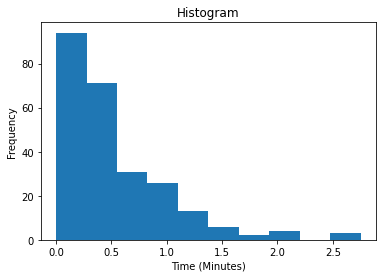

Sample size:  250


In [3]:
y = np.loadtxt('sec05.csv')
plt.hist(y)
plt.xlabel('Time (Minutes)')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()
print('Sample size: ', len(y))

### Bayesian Model Setup
The bank manager wants to get some prior knowledge of the unknown parameter $\lambda$.

He asks the head of the bank, "Can you give me some information about the delay rate?"

The head of the bank replies, "I believe the delay rate $\lambda$ is gamma-distributed with $\alpha = 2$ and $\beta = 2$."
 --- -------------------------------------------------------------------------------------------
With the above information, the bank manager sets up a Bayesian model. **The prior density** $p(\lambda)$ in the model is a gamma density with alpha=2 and beta=2. That is 

$$p(\lambda) = \frac{\lambda^{\alpha-1}e^{-\beta\lambda}\beta^{\alpha}}{\Gamma(\alpha)}$$

**The likelihood density** $p(y|\lambda)$ in the model is the density of an IID sample from an $\text{Exp}(\lambda)$ distribution:

$$p(y|\lambda) = \prod_{i=1}^{n}p(y_i|\lambda)$$

In the next cell, plot the prior and likelihood densities over the given support of $\lambda$. You can use the in-built methods in scipy to compute these densities. **When using scipy.stats.gamma, $\texttt{a}=\alpha$, $\texttt{scale} = 1/\beta$**. **When using scipy.stats.expon, $\texttt{scale} = 1/\lambda$**.

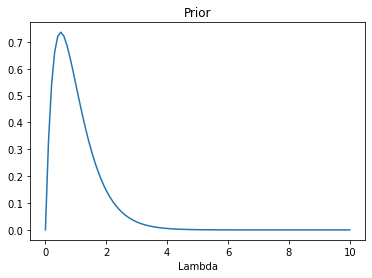

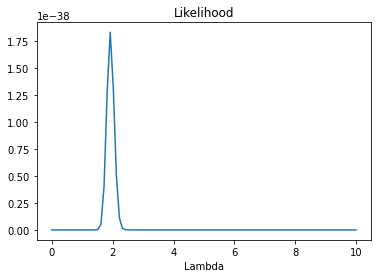

In [4]:
# given support of lambda
support = np.linspace(1e-16, 10, 100)

# define the prior here
alpha = 2
beta = 2

prior = stat.gamma.pdf(support, a=alpha, scale=1/beta)
plt.plot(support,prior)
plt.title('Prior')
plt.xlabel('Lambda')
plt.show()

# define the likelihood here
likelihood = []
for lam_i in support:
    likelihood.append(np.prod(stat.expon.pdf(y, scale=1/lam_i)))

plt.plot(support, likelihood)
plt.title('Likelihood')
plt.xlabel('Lambda')
plt.show()

### Posterior Density
Recall from Bayesian probability theory that the posterior density of $\lambda$ given the sample is 
$$p(\lambda|y) = \frac{p(\lambda)p(y|\lambda)}{\int p(\lambda)p(y|\lambda) d\lambda }$$

Help the bank manager. In the next cell:
1. Compute the posterior density at each point in the support.
2. Plot the density of a gamma distribution with $\alpha^{*} = 2 + \text{len}(y)$, $\beta^{*} = 2 + \text{sum}(y)$ overlaid with points for the posterior density evaluated on `support`.
3. What can you observe?

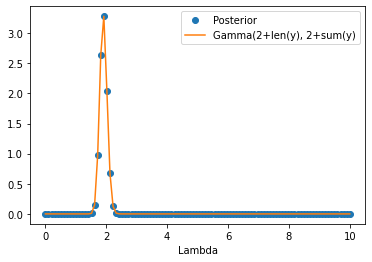

In [5]:
# def the posterior
jointDistribution = likelihood * prior
posterior = jointDistribution / np.trapz(jointDistribution, support)
plt.plot(support, posterior, 'o', label='Posterior')

# plot the Gamma(2+len(y), 2+sum(y)) density
alpha_star = alpha + len(y)
beta_star = beta + sum(y)
plt.plot(
    support, 
    stat.gamma.pdf(support, a=alpha_star, scale=1/beta_star), 
    label='Gamma(2+len(y), 2+sum(y)'
)
plt.xlabel('Lambda')
plt.legend()
plt.show()

**Discovery:** The posterior density is also a gamma denisty. This implies the gamma density is a conjugate prior density for an exponential likelihood. 

### Detour: [Conjugate Prior](https://en.wikipedia.org/wiki/Conjugate_prior)

In Bayesian probability theory, if the posterior distribution is in the same family as the prior distribution, the prior and posterior distributions are called conjugate.

**Question: Why does conjugacy matter?**
It lets us update the posterior distribution using new data very easily!

## Estimation of Unknown Parameter
With the posterior density, the bank manager can estimate the unknown parameter $\lambda$. In this part, we will explore two [Bayesian estimators](https://en.wikipedia.org/wiki/Bayes_estimator).

### MAP estimator
A common Bayesian estimator is the maximum a posteriori or MAP estimator:

$$\hat{\lambda}_{\text{MAP}} = \underset{\lambda}{\text{argmax}} \ P(\lambda|y) = \underset{\lambda}{\text{argmax}} \ \log P(\lambda|y)$$

We already know the posterior is Gamma($\tilde{\alpha},\tilde{\beta})$:
$$p(\lambda|y) = \frac{\lambda^{\tilde{\alpha}-1}e^{-\tilde{\beta}\lambda}\beta^{\tilde{\alpha}}}{\Gamma(\tilde{\alpha})}$$
where $\tilde{\alpha} = 2+\text{len}(y)$, $\tilde{\beta} = 2+\text{sum}(y)$.

Help the manager and compute $\hat{\lambda}_{\text{MAP}}$.

In [6]:
# MAP estimation

# Method 1: 
lam_MAP_1 = support[np.where(posterior == max(posterior))]

# Method 2: closed form of MAP estimator
alpha_tilde = alpha + len(y)
beta_tilde = beta + sum(y)
lam_MAP_2 = (alpha_tilde - 1) / beta_tilde

print("MAP Estimate, numerical optimization:", lam_MAP_1[0])
print("MAP Estimate, closed form:", lam_MAP_2)

MAP Estimate, numerical optimization: 1.9191919191919191
MAP Estimate, closed form: 1.898710532892983


### MMSE estimator
Another famous Bayesian estimator is the minimum mean squared error estimator (also called Bayesian least square estimator). In our model, the BLS estimator for $\lambda$ is

$$\hat{\lambda}_{BLS} = E[\lambda|y]$$

Compute the BLS estimator for $\lambda$ in the next cell.

In [7]:
# Compute the BLS estimator
lam_BLS = np.trapz(support * posterior, support)
print("The BLS estimator is:", lam_BLS)

The BLS estimator is: 1.9062751167072105


**Conclusions:**
The bank manager has gotten several close estimates of the delay rate $\lambda$. As the number of input samples grows, he will get better and better estimations. 

## Importance Sampling

We have seen that the posterior density is crucial for Bayesian inference. However, in practice, it can be hard to compute the posterior density because of the normalization in the denominator of its formula. 

Fortunately, we do not always need to know the true posterior density. We can still do a lot if we can get the expectation of the posterior distribution, or at least an approximation thereof.

---------- --------------------------------------------------------------------------------------

In the following cell, try to use importance sampling to compute the expectation of the posterior distribution. Importance sampling can be described as follows.

Let $q(\lambda)$ be a proposal density and $p(\lambda | y)$ be the target posterior density. Let $p_0(\lambda | y)$ be the unnormalized posterior density, which is easy to compute:

$$p_0(\lambda | y) = p(\lambda) p(y | \lambda)$$

Under this set up, the expectation of the posterior distribution can be approximated as

$$E[\lambda|y] \approx \sum_{i} \frac{w(\lambda_i)}{\sum_j w(\lambda_j)} \lambda_i$$

where $\lambda_i$ are samples from the proposal distribution, and $w(\lambda_i)$ are the importance weights

$$w(\lambda_i) = \frac{p_0(\lambda_i | y)}{q(\lambda_i)}$$

Here, take the proposal distribution as a uniform[0,4] distribution. **Note: when generating samples from the proposal distribution, please set random_state = 636**

(See the first page of `sec06_importance_sampling.pdf` for more context on importance sampling. Equation (4) gives the formula we want to implement.)

In [8]:
# unnormalized posterior density
p0 = lambda lam_i : \
    stat.gamma.pdf(lam_i, a=2, scale=1/2) * \
    np.prod(stat.expon.pdf(y, scale = 1/lam_i))

# proposal density
q = lambda lam_i : stat.uniform.pdf(lam_i, loc=0, scale=4)

# weight function
w = lambda lam_i: p0(lam_i) / q(lam_i)

# get samples from proposal distribution
lam = stat.uniform.rvs(loc=0, scale=4, size=1000, random_state=636)

# estimate
w_i = np.vectorize(w)(lam)

est = w_i / np.sum(w_i) @ lam

print("The estimate from importance sampling is %.6f" % est)

(1000,) (1000,)
The estimate from importance sampling is 1.913339
